In [66]:
import pathlib
from tqdm import tqdm
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np

import xarray as xr
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy
import scipy.stats as st
import os
import copy
import sys
# Import these costom functions from the toolbox
sys.path.insert(1, './tools/')
import metrics
import signatures
import analysis_tools

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [2]:
# NOTEBOOK SETUP.
# CHOSE OPTIONS, PATHS, DATE RANGES, ETC. HERE IN THIS CELL

# Options for what to calculate
# Calulations will be saved to pkl
# If False, will load in pkl files
######################################
calculate_metric_dictionary = False #
calculate_flow_categories = False   #
calculate_metric_matrix = False     #
######################################

val_start='10/01/1989'
val_end='09/30/1999'
date_range = pd.date_range(start=val_start, end=val_end)

# Specifics about the analysis to use. 
all_metrics = ['NSE', 'Alpha-NSE', 'Pearson-r', 'Beta-NSE', 'FHV', 'FMS', 'FLV', 'Peak-Timing']
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,3,7]
# Plotting parameters for the metrics defined above.
disp_bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
disp_colors = {'base_model':'PRGn', 'lagged_streamflow_both':'PRGn'} 

# local directory with all data
# not included in github
data_dir = "./data/"
run_dir = "/home/gsnearing/projects/data_assimilation/runs/"

In [3]:
if False: # Open the attributes set up to do regression
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0_Regression.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0.csv'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')

# Catchment attributes and hydrologic signatures that are not useful
drop_these = ['high_prec_timing','root_depth_50', 'root_depth_99','zero_q_freq','water_frac','organic_frac',
              'low_prec_timing', 'geol_1st_class','dom_land_cover','other_frac']
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
df = copy.deepcopy(attributes)
df = df.dropna(axis=1)

In [4]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [5]:
results = {}
with open(run_dir+"simulation/simulation_0_0206_025210/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['sim'] = pkl.load(fb)
with open(run_dir+"simulation/assimilation/0.0_1_0/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['da'] = pkl.load(fb)
with open(run_dir+"autoregression_50_holdout/test/0.0_1_0/test/model_epoch030/"+"test_results.p", "rb") as fb:
    results['ar'] = pkl.load(fb)


In [6]:
static_attributes = ['elev_mean','slope_mean','area_gages2',
'frac_forest','lai_max','lai_diff','gvf_max',
'gvf_diff','soil_depth_pelletier','soil_depth_statsgo','soil_porosity',
'soil_conductivity','max_water_content','sand_frac','silt_frac','clay_frac',
'carbonate_rocks_frac','geol_permeability','p_mean','pet_mean','aridity',
'frac_snow','high_prec_freq','high_prec_dur','low_prec_freq','low_prec_dur']


In [7]:
basin_list = results['sim'].keys()

In [8]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [9]:
df = df.set_index('basin_id_str').loc[basin_list,:]

In [10]:
df['nse_sim'] = np.nan
df['nse_ar'] = np.nan
df['nse_da'] = np.nan
df['nse_ar-sim'] = np.nan
df['nse_da-sim'] = np.nan
df['nse_da-ar'] = np.nan

In [11]:
for basin in basin_list:
#     df['nse_sim'] = metrics.nse(results['sim'][basin]['1D']['xr']['QObs(mm/d)_obs'], 
#                                 results['sim'][basin]['1D']['xr']['QObs(mm/d)_sim'])
    df.loc[basin,'nse_sim'] = results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar'] = results['ar'][basin]['1D']['NSE']
    df.loc[basin,'nse_da'] = results['da'][basin]['1D']['NSE']
    df.loc[basin,'nse_ar-sim'] = results['ar'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-sim'] = results['da'][basin]['1D']['NSE'] - results['sim'][basin]['1D']['NSE']
    df.loc[basin,'nse_da-ar'] = results['da'][basin]['1D']['NSE'] - results['ar'][basin]['1D']['NSE']

In [26]:
df.columns.values[:-6]

array(['p_mean', 'pet_mean', 'p_seasonality', 'frac_snow', 'aridity',
       'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur',
       'glim_1st_class_frac', 'glim_2nd_class_frac',
       'carbonate_rocks_frac', 'geol_permeability', 'frac_forest',
       'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
       'dom_land_cover_frac', 'soil_depth_pelletier',
       'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
       'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
       'gauge_lat', 'gauge_lon', 'elev_mean', 'slope_mean', 'area_gages2',
       'area_geospa_fabric', 'baseflow_index'], dtype=object)

In [49]:
# Multi-linear Regression in a K-fold loop
def cross_val_lr(X,y,feature_list,kf,ynormal=False, title='scatterplottitle', corr_matrix=None):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_test_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,8.04))
    grid = plt.GridSpec(2, 3, wspace=0.33333)
    plt.subplot(grid[0, :2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_hat = lr.predict(X_test)

        # Get numerical feature importances
        importances = list(lr.coef_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
#        plt.scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_test_list.extend(y_test)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()


    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    #############       Positive or Negative color coded importances
    if corr_matrix is not None:
        bar_colorz=[]
        bar_labelz=[]
        for feature_importance in feature_importances.index.values:
            if corr_matrix.loc[feature_importance]>0:
                bar_colorz.append('b')
                bar_labelz.append('positive')
            elif corr_matrix.loc[feature_importance]<0:
                bar_colorz.append('r')
                bar_labelz.append('negative')
            else:
                bar_colorz.append('black')
                bar_labelz.append('noncorrelated')
    else:
        #############        Do a regular linear regression, so we know if the correlation is Positive or Negative
        lr = LinearRegression()
        lr.fit(X, y)
        linear_coefficients = lr.coef_
        print(lr.predict)
        slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, lr.predict())
        print('multi-linear regression r2:', overall_r_value)
        bar_colorz=list(np.where(lr.coef_>0, 'b', 'r'))
        bar_labelz=list(np.where(lr.coef_>0, 'positive', 'negative'))
    feature_importances.loc[:, 'bar_colorz'] = bar_colorz
    feature_importances.loc[:, 'bar_labelz'] = bar_labelz
    feature_importances = feature_importances.sort_values('total_importance', ascending=False)
    #############       Positive or Negative color coded importances
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    
    plt.scatter(y_test_list,y_hat_list, c='b', label='r2 = {:.2f}'.format(np.nanmean(np.array(r2_list))))
    plt.title(title)
    plt.xlabel("true target values")
    plt.ylabel("predicted values")
    
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept, label='slope:{:.2f}, intercept:{:.2f}'.format(slope,intercept))
    plt.plot([omin, omax],[omin, omax],'--',c='k',label='1 to 1 line')
    plt.grid()
    plt.legend()
    
    plt.subplot(grid[1, :])
    plt.bar(feature_importances.index.values,
            feature_importances.total_importance,
            color=feature_importances.bar_colorz,
            label=feature_importances.bar_labelz)
    
    # --------------   This is a hack to get the legend to show the color groups #-----#
    colors = {'negative correlation':'red', 'positive correlation':'blue'}       #-----#
    labels = list(colors.keys())                                                 #-----#
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]#-----#
    plt.legend(handles, labels)                                                  #-----#
    # --------------   This is a hack to get the legend to show the color groups #-----#

    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
#    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [50]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[], title='scatterplottitle', filename=None,
                 corr_matrix=None):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_test_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,8.04))
    grid = plt.GridSpec(2, 3, wspace=0.33333)
    plt.subplot(grid[0, :2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
#        plt.scatter(y_test,y_hat, c='b')
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_test_list.extend(y_test)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    print(feature_importances)
    
    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    #############       Positive or Negative color coded importances
    if corr_matrix is not None:
        bar_colorz=[]
        bar_labelz=[]
        for feature_importance in feature_importances.index.values:
            if corr_matrix.loc[feature_importance]>0:
                bar_colorz.append('b')
                bar_labelz.append('positive')
            elif corr_matrix.loc[feature_importance]<0:
                bar_colorz.append('r')
                bar_labelz.append('negative')
            else:
                bar_colorz.append('black')
                bar_labelz.append('noncorrelated')
    else:
        #############        Do a regular linear regression, so we know if the correlation is Positive or Negative
        lr = LinearRegression()
        lr.fit(X, y)
        linear_coefficients = lr.coef_
        print(lr.predict)
        slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, lr.predict())
        print('multi-linear regression r2:', overall_r_value)
        bar_colorz=list(np.where(lr.coef_>0, 'b', 'r'))
        bar_labelz=list(np.where(lr.coef_>0, 'positive', 'negative'))
    feature_importances.loc[:, 'bar_colorz'] = bar_colorz
    feature_importances.loc[:, 'bar_labelz'] = bar_labelz
    feature_importances = feature_importances.sort_values('total_importance', ascending=False)
    #############       Positive or Negative color coded importances
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    
    plt.scatter(y_test_list,y_hat_list, c='b', label='r2 = {:.2f}'.format(np.nanmean(np.array(r2_list))))
    plt.title(title)
    plt.xlabel("true target values")
    plt.ylabel("predicted values")
    
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept, label='slope:{:.2f}, intercept:{:.2f}'.format(slope,intercept))
    plt.plot([omin, omax],[omin, omax],'--',c='k',label='1 to 1 line')
    plt.grid()
    plt.legend()
    
    plt.subplot(grid[1, :])
    plt.bar(feature_importances.index.values,
            feature_importances.total_importance,
            color=feature_importances.bar_colorz,
            label=feature_importances.bar_labelz)
    
    # --------------   This is a hack to get the legend to show the color groups #-----#
    colors = {'negative correlation':'red', 'positive correlation':'blue'}       #-----#
    labels = list(colors.keys())                                                 #-----#
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]#-----#
    plt.legend(handles, labels)                                                  #-----#
    # --------------   This is a hack to get the legend to show the color groups #-----#

    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
#    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    if filename:
        fig.savefig(filename+'.pdf', dpi=300)
        fig.savefig(filename+'.png', dpi=300)
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [15]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [16]:
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [27]:
corr_matrix = df.corr().iloc[:,-6:]

                     total_importance
elev_mean                    0.035698
slope_mean                   0.023438
area_gages2                  0.039553
frac_forest                  0.044932
lai_max                      0.018701
lai_diff                     0.019737
gvf_max                      0.022443
gvf_diff                     0.030373
soil_depth_pelletier         0.028965
soil_depth_statsgo            0.02727
soil_porosity                0.020406
soil_conductivity            0.053349
max_water_content            0.042712
sand_frac                    0.078755
silt_frac                    0.063291
clay_frac                    0.044131
carbonate_rocks_frac         0.016956
geol_permeability            0.038462
p_mean                       0.022921
pet_mean                     0.044259
aridity                      0.044582
frac_snow                    0.035223
high_prec_freq               0.100435
high_prec_dur                0.033005
low_prec_freq                0.047758
low_prec_dur

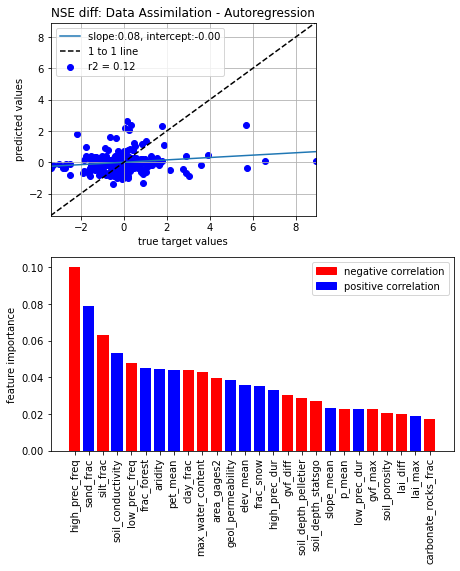

                     total_importance
elev_mean                    0.033708
slope_mean                   0.024564
area_gages2                  0.041033
frac_forest                  0.042855
lai_max                      0.019556
lai_diff                     0.022728
gvf_max                      0.022483
gvf_diff                     0.031964
soil_depth_pelletier         0.027131
soil_depth_statsgo           0.024302
soil_porosity                0.021843
soil_conductivity            0.054151
max_water_content            0.048813
sand_frac                    0.076723
silt_frac                    0.062248
clay_frac                    0.038167
carbonate_rocks_frac         0.016123
geol_permeability            0.039409
p_mean                       0.021009
pet_mean                     0.041653
aridity                      0.058976
frac_snow                     0.02988
high_prec_freq               0.104307
high_prec_dur                0.033494
low_prec_freq                0.042832
low_prec_dur

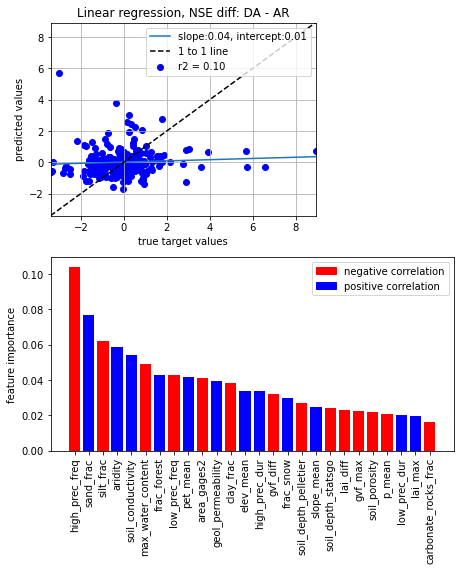

In [54]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_da-ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Autoregression', 
                filename='corr_diff_da_ar', corr_matrix=corr_matrix[target])

y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                  title='Linear regression, NSE diff: DA - AR',
                                                   corr_matrix=corr_matrix[target])

                     total_importance
elev_mean                    0.022342
slope_mean                   0.044848
area_gages2                  0.023517
frac_forest                  0.038342
lai_max                      0.020595
lai_diff                     0.024204
gvf_max                      0.023003
gvf_diff                     0.016943
soil_depth_pelletier         0.023565
soil_depth_statsgo             0.0163
soil_porosity                0.025761
soil_conductivity             0.04696
max_water_content            0.027192
sand_frac                    0.055027
silt_frac                    0.018569
clay_frac                    0.017986
carbonate_rocks_frac          0.01344
geol_permeability            0.026171
p_mean                       0.183158
pet_mean                     0.054376
aridity                      0.047719
frac_snow                     0.04793
high_prec_freq               0.147292
high_prec_dur                0.011482
low_prec_freq                0.013259
low_prec_dur

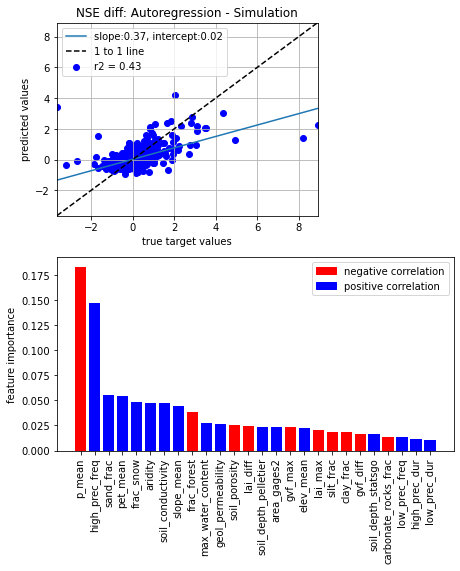

                     total_importance
elev_mean                    0.025353
slope_mean                   0.043402
area_gages2                  0.022459
frac_forest                  0.039702
lai_max                      0.019859
lai_diff                     0.023782
gvf_max                      0.022044
gvf_diff                     0.018816
soil_depth_pelletier         0.023191
soil_depth_statsgo            0.01418
soil_porosity                0.021401
soil_conductivity            0.043224
max_water_content            0.028229
sand_frac                    0.055436
silt_frac                    0.016132
clay_frac                    0.017674
carbonate_rocks_frac         0.012671
geol_permeability            0.027239
p_mean                       0.187664
pet_mean                     0.049757
aridity                      0.062689
frac_snow                    0.054606
high_prec_freq               0.137179
high_prec_dur                0.010141
low_prec_freq                0.014142
low_prec_dur

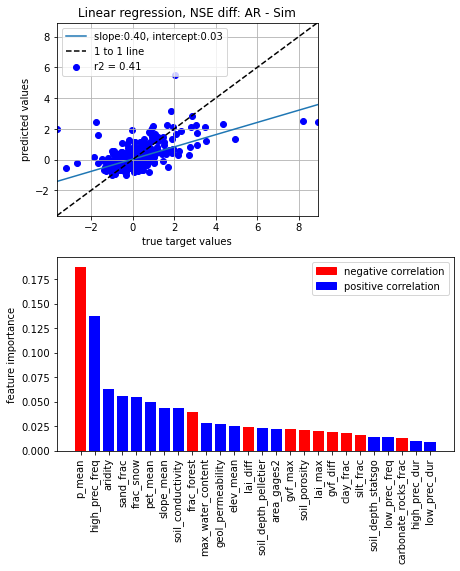

In [55]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_ar-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Autoregression - Simulation',
                filename='corr_diff_ar_sim', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, NSE diff: AR - Sim', 
                                                   corr_matrix=corr_matrix[target])


                     total_importance
elev_mean                    0.020571
slope_mean                   0.041623
area_gages2                   0.02228
frac_forest                  0.039911
lai_max                       0.01942
lai_diff                     0.024695
gvf_max                       0.02185
gvf_diff                     0.021566
soil_depth_pelletier          0.02686
soil_depth_statsgo           0.013623
soil_porosity                0.020024
soil_conductivity            0.049717
max_water_content             0.02581
sand_frac                    0.038822
silt_frac                    0.017023
clay_frac                    0.031525
carbonate_rocks_frac         0.013253
geol_permeability            0.027584
p_mean                       0.162022
pet_mean                     0.025447
aridity                      0.056911
frac_snow                    0.033064
high_prec_freq               0.200417
high_prec_dur                0.012762
low_prec_freq                0.020825
low_prec_dur

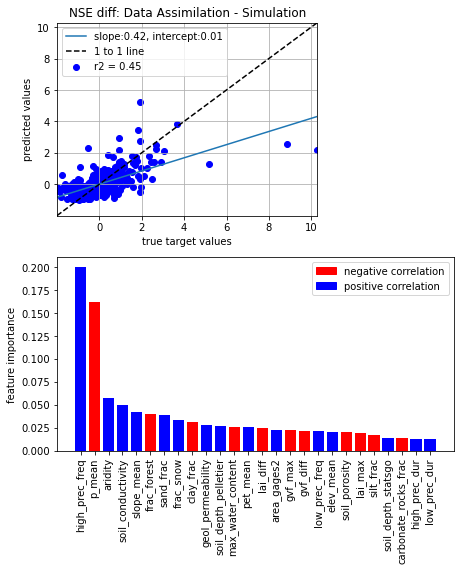

                     total_importance
elev_mean                    0.018664
slope_mean                   0.036435
area_gages2                  0.022871
frac_forest                  0.030328
lai_max                      0.024558
lai_diff                     0.026621
gvf_max                      0.019368
gvf_diff                     0.020465
soil_depth_pelletier          0.02792
soil_depth_statsgo           0.015717
soil_porosity                0.019278
soil_conductivity            0.043547
max_water_content            0.024556
sand_frac                    0.043036
silt_frac                     0.01726
clay_frac                    0.028918
carbonate_rocks_frac         0.012697
geol_permeability            0.026587
p_mean                       0.155475
pet_mean                     0.020907
aridity                      0.071606
frac_snow                    0.034066
high_prec_freq               0.214272
high_prec_dur                0.012156
low_prec_freq                0.021117
low_prec_dur

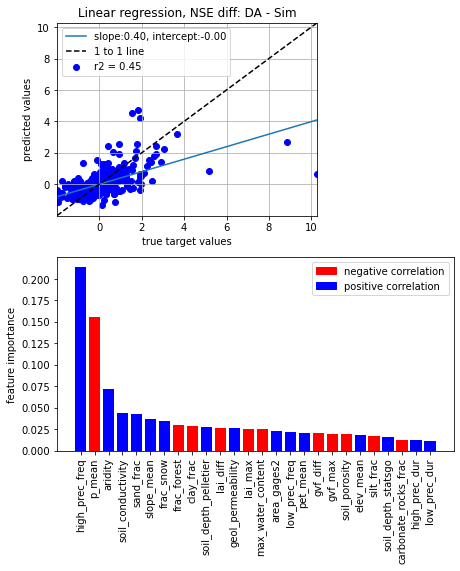

In [56]:
regressor_attributes = static_attributes#df.columns.values[:-6]

target='nse_da-sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE diff: Data Assimilation - Simulation',
                filename='corr_diff_da_sim', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, NSE diff: DA - Sim', 
                                                   corr_matrix=corr_matrix[target])


                     total_importance
elev_mean                    0.018178
slope_mean                   0.081643
area_gages2                  0.051434
frac_forest                  0.155311
lai_max                      0.019829
lai_diff                     0.012464
gvf_max                      0.028159
gvf_diff                     0.018163
soil_depth_pelletier         0.018937
soil_depth_statsgo           0.012714
soil_porosity                0.021498
soil_conductivity            0.011767
max_water_content            0.012618
sand_frac                    0.012478
silt_frac                    0.029762
clay_frac                    0.016353
carbonate_rocks_frac         0.009419
geol_permeability            0.016144
p_mean                       0.057003
pet_mean                     0.023852
aridity                        0.0689
frac_snow                    0.020228
high_prec_freq               0.056014
high_prec_dur                0.029047
low_prec_freq                0.177671
low_prec_dur

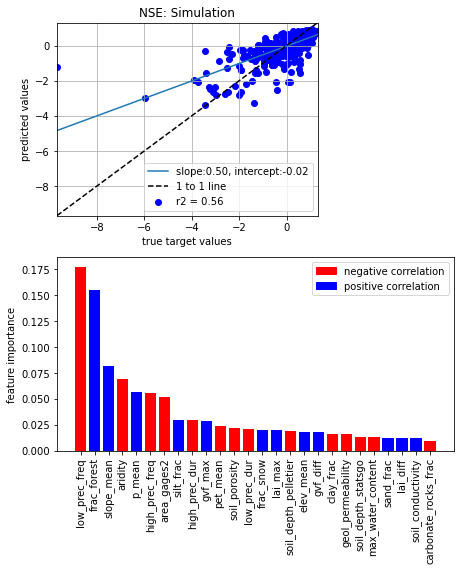

                     total_importance
elev_mean                    0.022581
slope_mean                   0.086531
area_gages2                  0.051605
frac_forest                  0.134724
lai_max                      0.020612
lai_diff                     0.013074
gvf_max                      0.021735
gvf_diff                     0.018576
soil_depth_pelletier         0.019449
soil_depth_statsgo           0.011887
soil_porosity                0.022839
soil_conductivity            0.010952
max_water_content            0.011508
sand_frac                    0.013042
silt_frac                    0.026896
clay_frac                     0.01542
carbonate_rocks_frac         0.007075
geol_permeability            0.017654
p_mean                       0.059514
pet_mean                     0.019199
aridity                      0.091489
frac_snow                     0.02092
high_prec_freq               0.065107
high_prec_dur                0.030604
low_prec_freq                0.168538
low_prec_dur

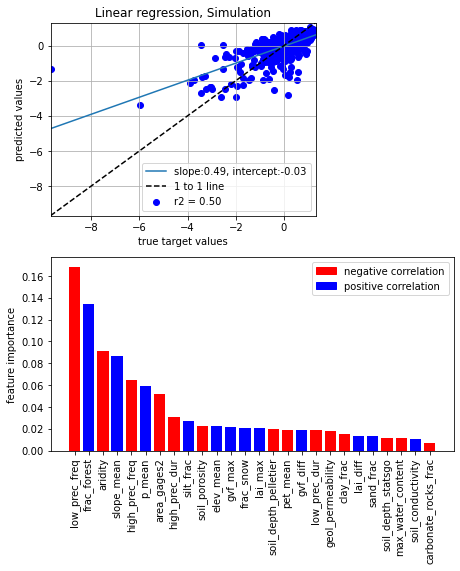

In [57]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]
feature_list_short = []
target='nse_sim'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Simulation',
                filename='corr_simulation', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Simulation', 
                                                   corr_matrix=corr_matrix[target])


                     total_importance
elev_mean                    0.019835
slope_mean                   0.045815
area_gages2                  0.065943
frac_forest                  0.031502
lai_max                      0.038662
lai_diff                     0.035117
gvf_max                       0.02883
gvf_diff                     0.016019
soil_depth_pelletier         0.015754
soil_depth_statsgo           0.008109
soil_porosity                0.016744
soil_conductivity            0.179722
max_water_content            0.014526
sand_frac                    0.023381
silt_frac                    0.026491
clay_frac                    0.031641
carbonate_rocks_frac          0.00506
geol_permeability            0.020139
p_mean                       0.026508
pet_mean                      0.01809
aridity                      0.042265
frac_snow                    0.133753
high_prec_freq               0.044386
high_prec_dur                0.021008
low_prec_freq                0.072074
low_prec_dur

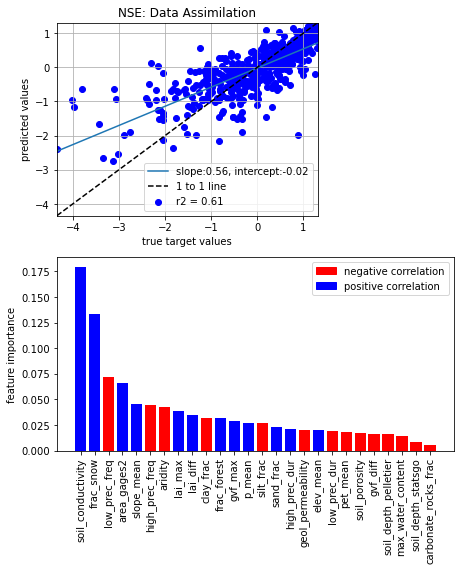

                     total_importance
elev_mean                    0.020996
slope_mean                   0.060208
area_gages2                  0.064016
frac_forest                  0.027122
lai_max                      0.037073
lai_diff                     0.036986
gvf_max                      0.024087
gvf_diff                     0.018183
soil_depth_pelletier         0.015376
soil_depth_statsgo           0.008504
soil_porosity                0.020534
soil_conductivity            0.163928
max_water_content            0.013366
sand_frac                    0.023845
silt_frac                    0.025266
clay_frac                    0.029542
carbonate_rocks_frac         0.004852
geol_permeability            0.018794
p_mean                       0.025824
pet_mean                     0.017301
aridity                      0.041879
frac_snow                    0.136743
high_prec_freq               0.045384
high_prec_dur                0.022582
low_prec_freq                0.077792
low_prec_dur

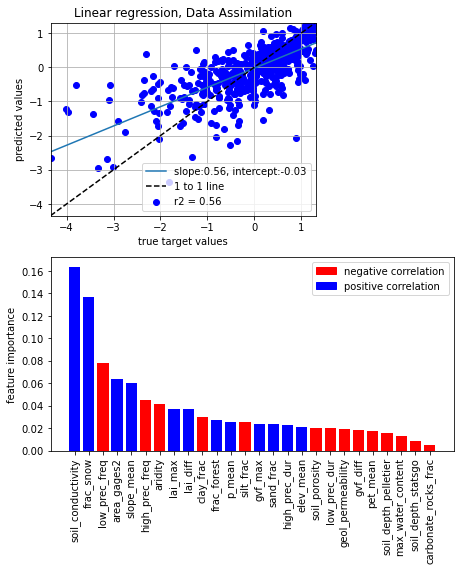

In [58]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]

feature_list_short = []
target='nse_da'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Data Assimilation',
                filename='corr_data_assimilation', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Data Assimilation', 
                                                   corr_matrix=corr_matrix[target])


                     total_importance
elev_mean                    0.022893
slope_mean                    0.04908
area_gages2                  0.079071
frac_forest                  0.025663
lai_max                      0.028606
lai_diff                     0.027553
gvf_max                      0.029502
gvf_diff                     0.016179
soil_depth_pelletier          0.01758
soil_depth_statsgo           0.007828
soil_porosity                0.022693
soil_conductivity            0.066952
max_water_content            0.019191
sand_frac                    0.025958
silt_frac                    0.036951
clay_frac                    0.030839
carbonate_rocks_frac         0.008092
geol_permeability            0.025565
p_mean                       0.021483
pet_mean                     0.022048
aridity                      0.030173
frac_snow                    0.128978
high_prec_freq               0.053179
high_prec_dur                0.028452
low_prec_freq                0.160752
low_prec_dur

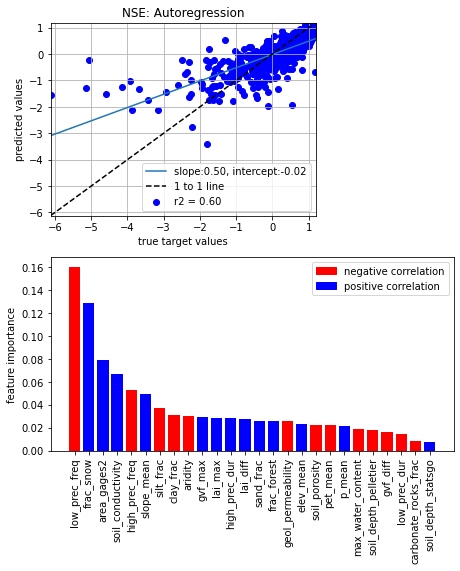

                     total_importance
elev_mean                     0.02385
slope_mean                   0.057377
area_gages2                  0.078327
frac_forest                  0.018919
lai_max                      0.030177
lai_diff                     0.024799
gvf_max                      0.030025
gvf_diff                      0.01573
soil_depth_pelletier         0.018208
soil_depth_statsgo           0.007614
soil_porosity                0.024151
soil_conductivity            0.070601
max_water_content            0.016096
sand_frac                     0.02574
silt_frac                    0.034346
clay_frac                    0.029568
carbonate_rocks_frac         0.006941
geol_permeability            0.029169
p_mean                        0.01622
pet_mean                     0.025267
aridity                      0.029246
frac_snow                     0.11538
high_prec_freq               0.059128
high_prec_dur                0.031227
low_prec_freq                0.166172
low_prec_dur

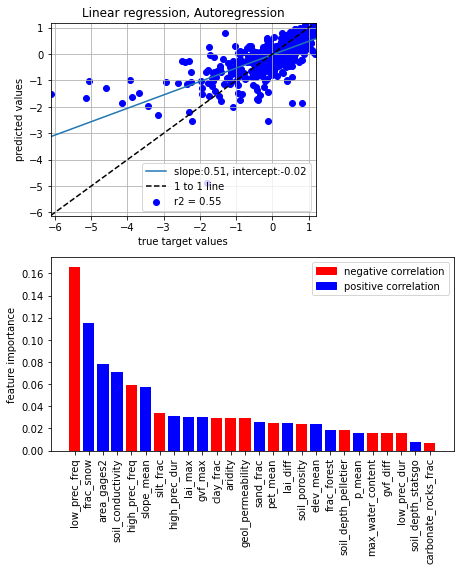

In [59]:
# Make a dictionary for all the X, y values
regressor_attributes = static_attributes#df.columns.values[:-6]

feature_list_short = []
target='nse_ar'
ynormal = True
X, y = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=20, shuffle=True)
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, title='NSE: Autoregression',
                filename='corr_autoregression', corr_matrix=corr_matrix[target])
y_hat, rmse, r2, feature_importance = cross_val_rf(X,y,regressor_attributes,kf,ynormal=ynormal,
                                                   title='Linear regression, Autoregression', 
                                                   corr_matrix=corr_matrix[target])


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


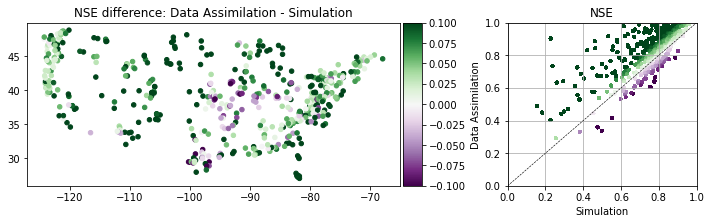

/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


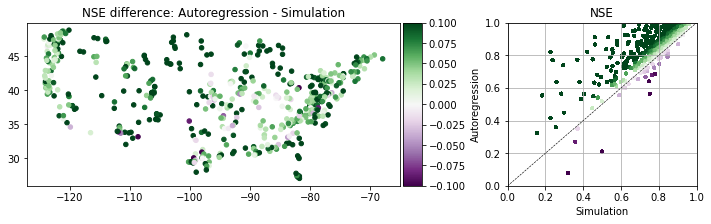

In [140]:

test_model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression'}

for test_model in ['nse_da', 'nse_ar']:
    
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,test_model+'-sim'],
                    s=20,
                    cmap='PRGn',
                    vmin=-.1, vmax=.1)
    ax0.set_title('NSE difference: {} - Simulation'.format(test_model_label_map[test_model]))
    clims = im.get_clim()

    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax1 = fig.add_subplot(gs[0,7:])
    ax1.plot([0, 1],[0,1], 'k--', lw=0.6)
    for b, basin in enumerate(basin_list):
        basin_color = im.to_rgba(df.loc[:,test_model+'-sim'])
        ax1.scatter(df.loc[:,'nse_sim'],
                    df.loc[:,test_model],
                    s=5,
                    color=basin_color)
    ax1.set_title('NSE')
    ax1.set_xlabel('Simulation')
    ax1.set_ylabel(test_model_label_map[test_model])
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.grid()

    plt.tight_layout()
    plt.show()
    fig.savefig('./figs/map_'+test_model+'.pdf', dpi=300)
    fig.savefig('./figs/map_'+test_model+'.png', dpi=300)
    plt.close()

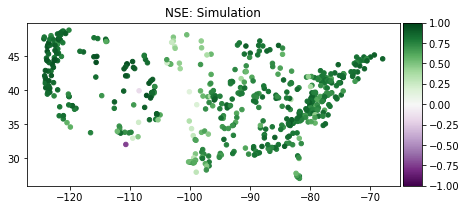

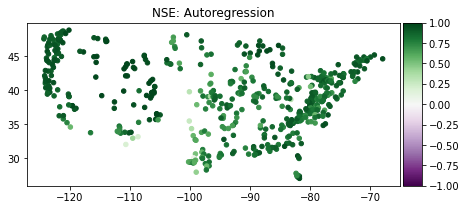

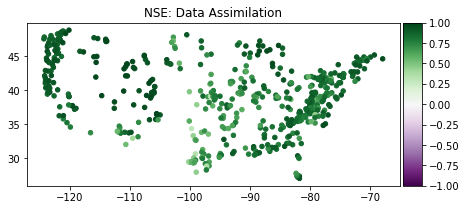

In [91]:
model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression', 'nse_sim':'Simulation'}
for model in ['nse_sim', 'nse_ar', 'nse_da']:
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,model],
                    s=20,
                    cmap='PRGn',
                    vmin=-1, vmax=1)
    ax0.set_title('NSE: {}'.format(model_label_map[model]))
    clims = im.get_clim()
    
    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')


/home/jmframe/programs/anaconda3/envs/mc-paper/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


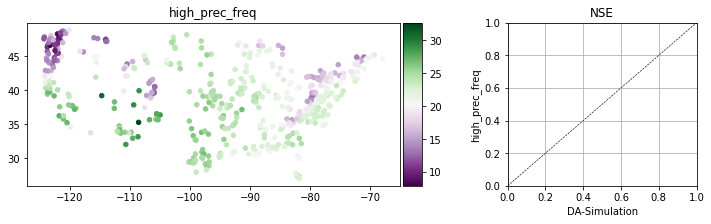

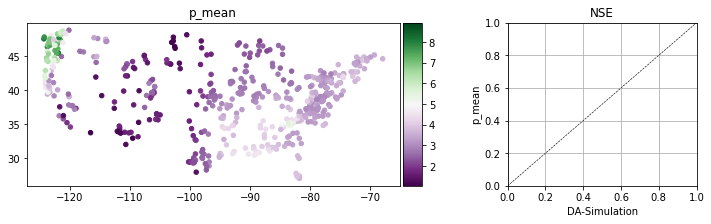

In [65]:
test_model_label_map = {'nse_da':'Data Assimilation', 'nse_ar':'Autoregression'}

for plot_variable in ['high_prec_freq', 'p_mean']:
    
    gs = plt.GridSpec(1, 10, wspace=0.33333)
    fig = plt.figure(figsize=(12, 3))
    ax0 = fig.add_subplot(gs[0,:6])
    im = ax0.scatter(plot_lons, plot_lats,
                    c=df.loc[:,plot_variable],
                    s=20,
                    cmap='PRGn',
                    vmin=np.min(df.loc[:,plot_variable]), vmax=np.max(df.loc[:,plot_variable]))
    ax0.set_title(plot_variable)
    clims = im.get_clim()

    # colorbar
    divider = make_axes_locatable(ax0)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    ax1 = fig.add_subplot(gs[0,7:])
    ax1.plot([0, 1],[0,1], 'k--', lw=0.6)
    for b, basin in enumerate(basin_list):
        basin_color = im.to_rgba(df.loc[:,plot_variable])
        ax1.scatter(df.loc[:,'nse_da-sim'],
                    df.loc[:,plot_variable],
                    s=5,
                    color=basin_color)
    ax1.set_title('NSE')
    ax1.set_xlabel('DA-Simulation')
    ax1.set_ylabel(plot_variable)
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.grid()

    plt.tight_layout()
    plt.show()
    plt.close()